In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split

from src.FramePrediction import NextFrameConvLSTM, NextFrameUNet

In [3]:
TIMESTEPS = 3  # number of timesteps between current and future state

X = []
Y = []

folders = [f.name for f in os.scandir("data") if f.is_dir()]
folders = [int(n) for n in folders]
folders.sort()

for folder in folders:

    print(f"Loading {folder}", end="\r")
    
    s = np.load(f"data/{folder}/smoke.npy")
    s = np.expand_dims(s, -1)
    velocity = np.load(f"data/{folder}/velocity.npy")
    p = np.load(f"data/{folder}/pressure.npy")
    p = np.expand_dims(p, -1)
    inflow = np.repeat(s[[0],:,:,:], 150, axis=0)
    
    x = np.concatenate([s, velocity, p, inflow], axis=-1)  # Density, Velocity X, Velocity Y, Pressure
    
    x_prev = x[:-2*TIMESTEPS]            # t-1
    x_current = x[TIMESTEPS:-TIMESTEPS]  # t
    y = x[2*TIMESTEPS:]                  # t+1

    # Concatenate x_prev and x along a new (time) dimension
    x = np.concatenate([np.expand_dims(x_prev, 1), np.expand_dims(x_current, 1)], axis=1)
    
    X.append(x)
    Y.append(y)

X = np.concatenate(X, axis=0)
Y = np.concatenate(Y, axis=0)

X.shape, Y.shape

((14400, 2, 64, 64, 5), (14400, 64, 64, 5))

In [4]:
# Move channel dimension to third position
X = np.moveaxis(X, 4, 2)
Y = np.moveaxis(Y, 3, 1)

# Add time dimension to target
Y = np.expand_dims(Y, 1)

# Shape: (B, T, C, H, W)
X.shape, Y.shape

((14400, 2, 5, 64, 64), (14400, 1, 5, 64, 64))

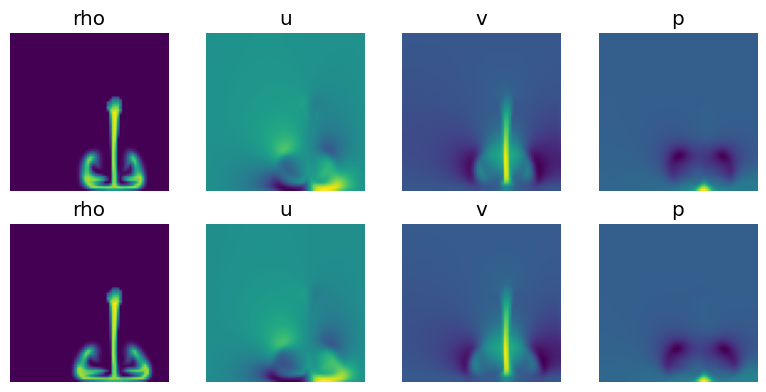

In [5]:
idx = 59

fig, axs = plt.subplots(2, 4, figsize=(8,4))

# Current frame (index, time, channel, height, width)
axs[0,0].imshow(X[idx,1,0,:,:])
axs[0,0].set_title("rho")
axs[0,0].axis("off")

axs[0,1].imshow(X[idx,1,1,:,:])
axs[0,1].set_title("u")
axs[0,1].axis("off")

axs[0,2].imshow(X[idx,1,2,:,:])
axs[0,2].set_title("v")
axs[0,2].axis("off")

axs[0,3].imshow(X[idx,1,3,:,:])
axs[0,3].set_title("p")
axs[0,3].axis("off")

# Next frame
idx_next = idx + 5
axs[1,0].imshow(Y[idx,0,0,:,:])
axs[1,0].set_title("rho")
axs[1,0].axis("off")

axs[1,1].imshow(Y[idx,0,1,:,:])
axs[1,1].set_title("u")
axs[1,1].axis("off")

axs[1,2].imshow(Y[idx,0,2,:,:])
axs[1,2].set_title("v")
axs[1,2].axis("off")

axs[1,3].imshow(Y[idx,0,3,:,:])
axs[1,3].set_title("p")
axs[1,3].axis("off")

plt.tight_layout()

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

In [7]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF


print(torch.cuda.is_available())

for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i))

False


In [8]:
def get_physics_loss(predicted_state, initial_state, force_f, inflow_i, dt, dx, dy, nu, alpha):
    """
    Calculates the physics-informed loss from the PDE residuals.

    Args:
        predicted_state (torch.Tensor): Model output (B, 1, C, H, W).
        initial_state (torch.Tensor): Model input (B, 1, C, H, W).
        force_f (torch.Tensor): Buoyancy force field (B, 2, H, W), where C=2 for (fx, fy).
        inflow_i (torch.Tensor): Smoke inflow field (B, 1, H, W).
        dt, dx, dy (float): Discretization steps.
        nu, alpha (float): Physical constants (kinematic viscosity, diffusivity).
    """
    # Squeeze the time dimension, T=1
    pred = predicted_state.squeeze(1) # Shape: (B, C, H, W)
    init = initial_state.squeeze(1)   # Shape: (B, C, H, W)

    # Unpack channels. Your channels are (concentration, u, v, pressure)
    s_pred, u_pred, v_pred, p_pred = torch.split(pred, 1, dim=1)
    s_init, u_init, v_init, _ = torch.split(init, 1, dim=1)
    
    # Unpack force components
    fx, fy = torch.split(force_f, 1, dim=1)

    # --- Helper functions for derivatives (using convolution) ---
    def spatial_derivative(tensor, axis, dx):
        kernel = torch.tensor([[[[0, 0, 0], [0.5, 0, -0.5], [0, 0, 0]]]], 
                              dtype=tensor.dtype, device=tensor.device)
        if axis == 1: kernel = kernel.permute(0, 1, 3, 2)
        return F.conv2d(tensor, kernel, padding='same') / dx

    def laplacian(tensor, dx, dy):
        kernel = torch.tensor([[[[0, 1, 0], [1, -4, 1], [0, 1, 0]]]], 
                              dtype=tensor.dtype, device=tensor.device)
        return F.conv2d(tensor, kernel, padding='same') / (dx*dy)

    # --- Calculate all required derivatives of the predicted state ---
    # Temporal derivatives
    d_s_dt = (s_pred - s_init) / dt
    d_u_dt = (u_pred - u_init) / dt
    d_v_dt = (v_pred - v_init) / dt
    
    # Spatial derivatives
    d_u_dx = spatial_derivative(u_pred, axis=0, dx=dx)
    d_u_dy = spatial_derivative(u_pred, axis=1, dx=dy)
    d_v_dx = spatial_derivative(v_pred, axis=0, dx=dx)
    d_v_dy = spatial_derivative(v_pred, axis=1, dx=dy)
    d_s_dx = spatial_derivative(s_pred, axis=0, dx=dx)
    d_s_dy = spatial_derivative(s_pred, axis=1, dx=dy)
    d_p_dx = spatial_derivative(p_pred, axis=0, dx=dx) # Since rho=1
    d_p_dy = spatial_derivative(p_pred, axis=1, dx=dy)

    # Laplacians
    laplace_u = laplacian(u_pred, dx, dy)
    laplace_v = laplacian(v_pred, dx, dy)
    laplace_s = laplacian(s_pred, dx, dy)
    
    # --- Form the residuals ---
    residual_mom_x = d_u_dt + (u_pred * d_u_dx + v_pred * d_u_dy) + d_p_dx - nu * laplace_u - fx
    residual_mom_y = d_v_dt + (u_pred * d_v_dx + v_pred * d_v_dy) + d_p_dy - nu * laplace_v - fy
    residual_incomp = d_u_dx + d_v_dy
    residual_adv = d_s_dt + (u_pred * d_s_dx + v_pred * d_s_dy) - alpha * laplace_s - inflow_i

    # --- Calculate the final physics loss (Mean Squared Error of residuals) ---
    loss_physics = (torch.mean(residual_mom_x**2) +
                    torch.mean(residual_mom_y**2) +
                    torch.mean(residual_incomp**2) +
                    torch.mean(residual_adv**2))
                    
    return loss_physics


def get_boundary_loss(predicted_state):
    """
    Calculates the boundary condition loss for no-slip walls on all sides.
    """
    pred = predicted_state.squeeze(1) # Shape: (B, C, H, W)
    _, u_pred, v_pred, _ = torch.split(pred, 1, dim=1)

    # --- Calculate loss on each of the four walls ---
    loss_left_wall = torch.mean(u_pred[:, :, :, 0]**2) + torch.mean(v_pred[:, :, :, 0]**2)
    loss_right_wall = torch.mean(u_pred[:, :, :, -1]**2) + torch.mean(v_pred[:, :, :, -1]**2)
    loss_bottom_wall = torch.mean(u_pred[:, :, 0, :]**2) + torch.mean(v_pred[:, :, 0, :]**2)
    loss_top_wall = torch.mean(u_pred[:, :, -1, :]**2) + torch.mean(v_pred[:, :, -1, :]**2)
    
    total_bc_loss = loss_left_wall + loss_right_wall + loss_bottom_wall + loss_top_wall
    return total_bc_loss

In [10]:
class FramesDataset(Dataset):
    """Image dataset.
    """

    def __init__(self, frames_in, frame_out):
        self.frames_in = frames_in
        self.frame_out = frame_out
        self.num_frames = self.frames_in.shape[1]

    def __len__(self):
        return len(self.frames_in)

    def __getitem__(self, index):
        x = torch.from_numpy(self.frames_in[index])
        y = torch.from_numpy(self.frame_out[index])
        return x, y
    

def train(model, train_loader, val_loader,
         num_epochs=10, learning_rate=1e-4,
         early_stopping={'patience': 10, 'min_delta': 5e-5}):
    
    optimizer = Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, threshold=1e-4, mode='min', patience=3, factor=0.5, min_lr=1e-6)

    loss_history = {'train_loss': [], 'val_loss': []}
    early_stop_counter = 0
    best_val_loss = float('inf')
    
    lambda_phys = 0.1
    lambda_bc = 0.0
    teacher_forcing_ratio_max = 0.7  # Percentage of own predictions used as input

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    print(f"Using device: {device}")
    
    total_batches = len(train_loader)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        teacher_forcing_ratio = epoch / num_epochs * teacher_forcing_ratio_max

        # Training
        for i, (x, y) in enumerate(train_loader):
            
            optimizer.zero_grad()

            use_own_pred = np.random.random() < teacher_forcing_ratio

            previous_state = x.to(device)[:,[0],:4,:,:]  # (B, 1, C, H, W) time t-1

            if use_own_pred:
                initial_state = model(previous_state)
            else:
                initial_state = x.to(device)[:,[1],:4,:,:]  # (B, 1, C, H, W) time t

            target_state = y.to(device)[:,:,:4,:,:]
            
            # Smoke inflow field (B, 1, H, W)
            inflow_i = x[:,[0],4,:,:].to(device)

            # Buoyancy force field (B, 2, H, W), where C=2 for (fx, fy).
            fx = torch.zeros_like(inflow_i).to(device)
            s = x[:,[0],0,:,:]  # Smoke concentration
            fy = 0.1 * s
            force_f = torch.concat([fx,fy], dim=1).to(device)
            
            predicted_state = model(initial_state)
            
            # 1. Data Loss
            loss_mse = F.mse_loss(predicted_state, target_state)

            # 2. Physics Loss
            loss_physics = get_physics_loss(
                predicted_state, 
                initial_state, 
                force_f,
                inflow_i,
                dt=1.0, dx=100/64, dy=100/64, nu=0.0, alpha=0.0 # Simulation's parameters
            )

            # 3. Boundary Loss
            loss_bc = get_boundary_loss(predicted_state)

            # 4. Total Weighted Loss
            total_loss = loss_mse + lambda_phys * loss_physics + lambda_bc * loss_bc

            total_loss.backward()

            optimizer.step()

            train_loss += total_loss.item()

            print(f"(Epoch {epoch+1}) ({i+1}/{total_batches}) train_loss: {total_loss.item():.6f}", end="\r")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:

                initial_state = x.to(device)[:,[1],:4,:,:]  # (B, 1, C, H, W)
                target_state = y.to(device)[:,:,:4,:,:]
                
                # Smoke inflow field (B, 1, H, W)
                inflow_i = x[:,[0],4,:,:].to(device)

                # Buoyancy force field (B, 2, H, W), where C=2 for (fx, fy).
                fx = torch.zeros_like(inflow_i).to(device)
                s = x[:,[0],0,:,:]  # Smoke concentration
                fy = 0.1 * s
                force_f = torch.concat([fx,fy], dim=1).to(device)
                
                predicted_state = model(initial_state)
                
                # 1. Data Loss
                loss_mse = F.mse_loss(predicted_state, target_state)

                # 2. Physics Loss
                loss_physics = get_physics_loss(
                    predicted_state, 
                    initial_state, 
                    force_f,
                    inflow_i,
                    dt=1.0, dx=100/64, dy=100/64, nu=0.0, alpha=0.0 # Simulation's parameters
                )

                # 3. Boundary Loss
                loss_bc = get_boundary_loss(predicted_state)

                # 4. Total Weighted Loss
                total_loss = loss_mse + lambda_phys * loss_physics + lambda_bc * loss_bc

                val_loss += total_loss.item()
                
        val_loss /= len(val_loader.dataset)
        
        scheduler.step(val_loss)

        average_loss = train_loss / len(train_loader.dataset)
        current_lr = optimizer.param_groups[0]['lr']
        print(f'(Epoch {epoch+1}) train_loss: {average_loss:.6f}, val_loss: {val_loss:.6f}, lr: {current_lr}, teacher_forcing_ratio: {teacher_forcing_ratio:.4f}')

        loss_history['train_loss'].append(average_loss)
        loss_history['val_loss'].append(val_loss)

        # Early stopping
        if epoch > 0:
            if loss_history['val_loss'][-1] < best_val_loss - early_stopping['min_delta']:
                best_val_loss = loss_history['val_loss'][-1]
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= early_stopping['patience']:
                print('Early stopping.')
                break

    print('Training finished.')

    return loss_history

In [11]:
IN_CHANNELS = 4
HIDDEN_DIM = 8
KERNEL_SIZE = 3

BATCH_SIZE = 4
EPOCHS = 50

train_dataset = FramesDataset(X_train, Y_train)
test_dataset = FramesDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model = NextFrameConvLSTM(
    in_channels=IN_CHANNELS, 
    hidden_dim=HIDDEN_DIM, 
    kernel_size=KERNEL_SIZE,
    num_convlstm_layers=2,
    num_lstmcell_layers=2,
    batch_first=True
)

# model = NextFrameUNet(in_channels=IN_CHANNELS,
#                       out_channels=IN_CHANNELS,
#                       features=(4, 8, 16),
#                       use_transpose=False)

total_params = sum(p.numel() for p in model.parameters())
print('Total parameters in model:', total_params)

Total parameters in model: 18308


In [12]:
loss_history = train(model, train_loader, test_loader, num_epochs=EPOCHS, learning_rate=0.001)

Using device: cpu
(Epoch 1) train_loss: 0.004182, val_loss: 0.002390, lr: 0.001, teacher_forcing_ratio: 0.0000
(Epoch 2) train_loss: 0.002526, val_loss: 0.002097, lr: 0.001, teacher_forcing_ratio: 0.0140
(Epoch 3) train_loss: 0.002274, val_loss: 0.001881, lr: 0.001, teacher_forcing_ratio: 0.0280
(Epoch 4) train_loss: 0.002206, val_loss: 0.002056, lr: 0.001, teacher_forcing_ratio: 0.0420
(Epoch 5) train_loss: 0.002144, val_loss: 0.002968, lr: 0.001, teacher_forcing_ratio: 0.0560
(Epoch 6) train_loss: 0.002107, val_loss: 0.001719, lr: 0.001, teacher_forcing_ratio: 0.0700
(Epoch 7) train_loss: 0.002058, val_loss: 0.002014, lr: 0.001, teacher_forcing_ratio: 0.0840
(Epoch 8) train_loss: 0.002051, val_loss: 0.001860, lr: 0.001, teacher_forcing_ratio: 0.0980
(Epoch 9) train_loss: 0.002007, val_loss: 0.002241, lr: 0.001, teacher_forcing_ratio: 0.1120
(Epoch 10) train_loss: 0.002109, val_loss: 0.001979, lr: 0.0005, teacher_forcing_ratio: 0.1260
(Epoch 11) train_loss: 0.001888, val_loss: 0.00167

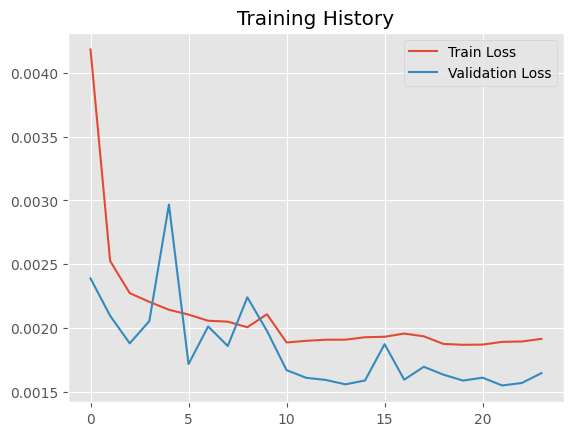

In [13]:
plt.plot(loss_history["train_loss"], label="Train Loss")
plt.plot(loss_history["val_loss"], label="Validation Loss")

plt.title("Training History")
plt.legend()

## Predict

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [74]:
idx = np.random.randint(len(test_dataset))
print(idx)

x, y_true = test_dataset[idx]
x = x[[1],:,:,:]
y_true = y_true[:,:4,:,:]

y_pred = model(x[:,:4,:,:].unsqueeze(0).to(device))  # Ignore inflow, only use [s, u, v, p]

x = x.cpu().detach().numpy().squeeze()
y_true = y_true.cpu().detach().numpy().squeeze()
y_pred = y_pred.cpu().detach().numpy().squeeze()

x.shape, y_pred.shape, y_true.shape

34


((5, 64, 64), (4, 64, 64), (4, 64, 64))

In [75]:
error = np.abs(y_true[:4] - y_pred)
error.max()

0.54132235

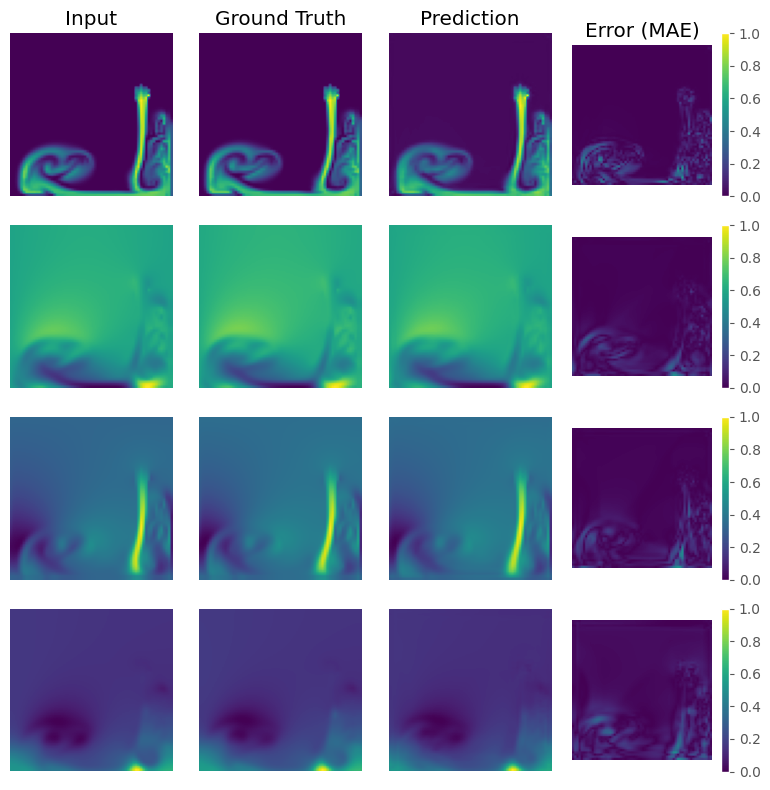

In [76]:
fig, axs = plt.subplots(4, 4, figsize=(8,8))

# Input
axs[0,0].imshow(x[0,:,:])
axs[0,0].set_title("Input")
axs[0,0].set_ylabel("rho")
axs[0,0].axis("off")

axs[1,0].imshow(x[1,:,:])
axs[1,0].set_ylabel("u")
axs[1,0].axis("off")

axs[2,0].imshow(x[2,:,:])
axs[2,0].set_ylabel("v")
axs[2,0].axis("off")

axs[3,0].imshow(x[3,:,:])
axs[3,0].set_ylabel("p")
axs[3,0].axis("off")

# Ground Truth
axs[0,1].imshow(y_true[0,:,:])
axs[0,1].set_title("Ground Truth")
axs[0,1].set_ylabel("rho")
axs[0,1].axis("off")

axs[1,1].imshow(y_true[1,:,:])
axs[1,1].set_ylabel("u")
axs[1,1].axis("off")

axs[2,1].imshow(y_true[2,:,:])
axs[2,1].set_ylabel("v")
axs[2,1].axis("off")

axs[3,1].imshow(y_true[3,:,:])
axs[3,1].set_ylabel("p")
axs[3,1].axis("off")

# Predicted
axs[0,2].imshow(y_pred[0,:,:])
axs[0,2].set_title("Prediction")
axs[0,2].set_ylabel("rho")
axs[0,2].axis("off")

axs[1,2].imshow(y_pred[1,:,:])
axs[1,2].set_ylabel("u")
axs[1,2].axis("off")

axs[2,2].imshow(y_pred[2,:,:])
axs[2,2].set_ylabel("v")
axs[2,2].axis("off")

axs[3,2].imshow(y_pred[3,:,:])
axs[3,2].set_ylabel("p")
axs[3,2].axis("off")

# Error
im = axs[0,3].imshow(error[0,:,:], vmin=0, vmax=1)
axs[0,3].set_title("Error (MAE)")
axs[0,3].set_ylabel("rho")
axs[0,3].axis("off")
plt.colorbar(im)

im = axs[1,3].imshow(error[1,:,:], vmin=0, vmax=1)
axs[1,3].set_ylabel("u")
axs[1,3].axis("off")
plt.colorbar(im)

im = axs[2,3].imshow(error[2,:,:], vmin=0, vmax=1)
axs[2,3].set_ylabel("v")
axs[2,3].axis("off")
plt.colorbar(im)

im = axs[3,3].imshow(error[3,:,:], vmin=0, vmax=1)
axs[3,3].set_ylabel("p")
axs[3,3].axis("off")
plt.colorbar(im)

plt.tight_layout()

In [70]:
i = 2

idx = 150 * i

x = torch.from_numpy(X[idx,[1],:4,:,:]).unsqueeze(0)

frames = [x.squeeze()]

for i in range(49):
    print(i, end="\r")
    x = model(x.to(device))
    frames.append(x.squeeze().cpu().detach().numpy())

frames = np.array(frames)

In [71]:
import numpy as np
from PIL import Image

def save_gif(smoke_array, velocity_array, pressure_array):
    # Scale to 0 - 255
    # NewValue = (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
    smoke_array_scaled = (((smoke_array - smoke_array.min()) * 255) / (smoke_array.max() - smoke_array.min())).astype(np.uint8)
    velocity_array_scaled = (((velocity_array - velocity_array.min()) * 255) / (velocity_array.max() - velocity_array.min())).astype(np.uint8)
    pressure_array_scaled = (((pressure_array - pressure_array.min()) * 255) / (pressure_array.max() - pressure_array.min())).astype(np.uint8)

    data_dict = {"rho": smoke_array_scaled,
                "u": velocity_array_scaled[:,:,:,0],
                "v": velocity_array_scaled[:,:,:,1],
                "p": pressure_array_scaled}

    for name, img_array in data_dict.items():

        imgs = [Image.fromarray(img) for img in img_array]
        # duration is the number of milliseconds between frames; this is 40 frames per second
        imgs[0].save(f"misc/{name}.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

In [72]:
# Load true data from simulation
s = np.load(f"data/{i}/smoke.npy")
velocity = np.load(f"data/{i}/velocity.npy")
p = np.load(f"data/{i}/pressure.npy")

s.shape, velocity.shape, p.shape

((150, 64, 64), (150, 64, 64, 2), (150, 64, 64))

In [73]:
smoke_array = frames[:,0,:,:]
velocity_array = np.moveaxis(frames[:,1:3,:,:], 1, 3)
pressure_array = frames[:,3,:,:]

# Pad pred arrays to same length
smoke_array = np.repeat(smoke_array, 3, axis=0)
velocity_array = np.repeat(velocity_array, 3, axis=0)
pressure_array = np.repeat(pressure_array, 3, axis=0)

# Prepare array for side-to-side comparison
smoke_array_big = np.zeros((smoke_array.shape[0], smoke_array.shape[1], smoke_array.shape[2]*2))
velocity_array_big = np.zeros((velocity_array.shape[0], velocity_array.shape[1], velocity_array.shape[2]*2, velocity_array.shape[3]))
pressure_array_big = np.zeros((pressure_array.shape[0], pressure_array.shape[1], pressure_array.shape[2]*2))

# Replace values
smoke_array_big[:,:,:64] = s
smoke_array_big[:,:,64:] = smoke_array
velocity_array_big[:,:,:64,:] = velocity
velocity_array_big[:,:,64:,:] = velocity_array
pressure_array_big[:,:,:64] = p
pressure_array_big[:,:,64:] = pressure_array

# Invert y-axis
smoke_array_big = smoke_array_big[:,::-1,:]
velocity_array_big = velocity_array_big[:,::-1,:,:]
pressure_array_big = pressure_array_big[:,::-1,:]

save_gif(smoke_array_big, velocity_array_big, pressure_array_big)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        out = self.double_conv(x)
        return out


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        out = self.pool_conv(x)
        return out

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_ch, out_ch, use_transpose=True):
        super().__init__()
        if use_transpose:
            self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)
        else:
            self.up = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_ch, in_ch // 2, kernel_size=1)
            )
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Fix size differences from pooling/upsampling
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        if diffY != 0 or diffX != 0:
            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)

        out = self.conv(x)
        return out


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class NextFrameUNet(nn.Module):
    """
    U-Net for next-frame prediction.
    - If input is (B, T, C, H, W) the last frame is used.
    - Output is (B, out_channels, H, W).
    """
    def __init__(self, in_channels=3, out_channels=3, features=(64, 128, 256), use_transpose=True):
        super().__init__()
        self.inc = DoubleConv(in_channels, features[0])
        self.downs = nn.ModuleList()
        for i in range(len(features) - 1):
            self.downs.append(Down(features[i], features[i + 1]))
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        rev_feats = list(reversed(features))
        self.ups = nn.ModuleList()
        up_in_ch = features[-1] * 2
        for f in rev_feats:
            self.ups.append(Up(up_in_ch, f, use_transpose=use_transpose))
            up_in_ch = f

        self.outc = OutConv(features[0], out_channels)

    def forward(self, x):
        if x.dim() == 5:  # (B, T, C, H, W)
            x = x[:, -1, :, :, :]

        # Encoder
        skips = []
        x = self.inc(x)
        skips.append(x)
        for down in self.downs:
            x = down(x)
            skips.append(x)

        # Bottleneck
        x = nn.MaxPool2d(2)(x)
        x = self.bottleneck(x)

        # Decoder
        for i, up in enumerate(self.ups):
            x = up(x, skips[-(i + 1)])

        out = self.outc(x)
        out = out.unsqueeze(1)  # (B, T, C, H, W)

        return out


if __name__ == "__main__":
    B, T, C, H, W = 8, 1, 4, 64, 64
    model = NextFrameUNet(in_channels=C, out_channels=C, features=(4, 8, 16))
    sample_seq = torch.randn(B, T, C, H, W)
    out = model(sample_seq)
    print("Output shape:", out.shape)


Output shape: torch.Size([8, 1, 4, 64, 64])


In [15]:
total_params = sum(p.numel() for p in model.parameters())
print('Total parameters in model:', total_params)

Total parameters in model: 30592
